In [12]:
import numpy as np
import pandas as pd
import os
import glob
import random
import string
from keras import Model
from keras.layers import Dropout, Flatten, Dense
from keras.src.applications import VGG16
from keras.utils import plot_model, set_random_seed
from keras.preprocessing.image import ImageDataGenerator

class CFG:
    batch_size = 64
    img_height = 64
    img_width = 64
    epochs = 30
    num_classes = 24
    img_channels = 3
    random_seed = 2501
    
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    set_random_seed(2501)
    


In [7]:
TRAIN_PATH = "/Users/teodorastereciu/PycharmProjects/mlp/data/asl_train/asl_alphabet_train"
labels = {i: letter for i, letter in enumerate(char for char in string.ascii_uppercase if char not in {'J', 'Z'})}
list_path = []
list_labels = []
for label in labels.values():
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

In [8]:
metadata

,image_path,label
0,/Users/teodorastereciu/PycharmProjects/mlp/dat...,A
1,/Users/teodorastereciu/PycharmProjects/mlp/dat...,A
2,/Users/teodorastereciu/PycharmProjects/mlp/dat...,A
3,/Users/teodorastereciu/PycharmProjects/mlp/dat...,A
4,/Users/teodorastereciu/PycharmProjects/mlp/dat...,A
...,...,...
71995,/Users/teodorastereciu/PycharmProjects/mlp/dat...,Y
71996,/Users/teodorastereciu/PycharmProjects/mlp/dat...,Y
71997,/Users/teodorastereciu/PycharmProjects/mlp/dat...,Y
71998,/Users/teodorastereciu/PycharmProjects/mlp/dat...,Y


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"], 
    test_size=0.15, 
    random_state=CFG.random_seed, 
    shuffle=True, 
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=CFG.random_seed,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

display(data_train)
display(data_val)
display(data_test)

,image_path,label
40282,/Users/teodorastereciu/PycharmProjects/mlp/dat...,O
19843,/Users/teodorastereciu/PycharmProjects/mlp/dat...,G
14301,/Users/teodorastereciu/PycharmProjects/mlp/dat...,E
36747,/Users/teodorastereciu/PycharmProjects/mlp/dat...,N
45398,/Users/teodorastereciu/PycharmProjects/mlp/dat...,Q
...,...,...
51642,/Users/teodorastereciu/PycharmProjects/mlp/dat...,S
28505,/Users/teodorastereciu/PycharmProjects/mlp/dat...,K
35409,/Users/teodorastereciu/PycharmProjects/mlp/dat...,M
34626,/Users/teodorastereciu/PycharmProjects/mlp/dat...,M


,image_path,label
4459,/Users/teodorastereciu/PycharmProjects/mlp/dat...,B
15075,/Users/teodorastereciu/PycharmProjects/mlp/dat...,F
61326,/Users/teodorastereciu/PycharmProjects/mlp/dat...,V
59015,/Users/teodorastereciu/PycharmProjects/mlp/dat...,U
26199,/Users/teodorastereciu/PycharmProjects/mlp/dat...,I
...,...,...
23980,/Users/teodorastereciu/PycharmProjects/mlp/dat...,H
55873,/Users/teodorastereciu/PycharmProjects/mlp/dat...,T
67160,/Users/teodorastereciu/PycharmProjects/mlp/dat...,X
45179,/Users/teodorastereciu/PycharmProjects/mlp/dat...,Q


,image_path,label
53851,/Users/teodorastereciu/PycharmProjects/mlp/dat...,S
70520,/Users/teodorastereciu/PycharmProjects/mlp/dat...,Y
58029,/Users/teodorastereciu/PycharmProjects/mlp/dat...,U
19728,/Users/teodorastereciu/PycharmProjects/mlp/dat...,G
8267,/Users/teodorastereciu/PycharmProjects/mlp/dat...,C
...,...,...
15488,/Users/teodorastereciu/PycharmProjects/mlp/dat...,F
31913,/Users/teodorastereciu/PycharmProjects/mlp/dat...,L
68122,/Users/teodorastereciu/PycharmProjects/mlp/dat...,X
19159,/Users/teodorastereciu/PycharmProjects/mlp/dat...,G


In [13]:
# Data Augmentation (Just Rescale)
def data_augmentation():
    datagen = ImageDataGenerator(
        rescale=1/255.,
    )
    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
        color_mode='grayscale',
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
        color_mode='grayscale',
    )
    
    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        color_mode='grayscale',
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

In [14]:
seed_everything(CFG.random_seed)
train_generator, validation_generator, test_generator = data_augmentation()

Found 48085 validated image filenames belonging to 24 classes.
Found 13115 validated image filenames belonging to 24 classes.
Found 10800 validated image filenames belonging to 24 classes.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

None

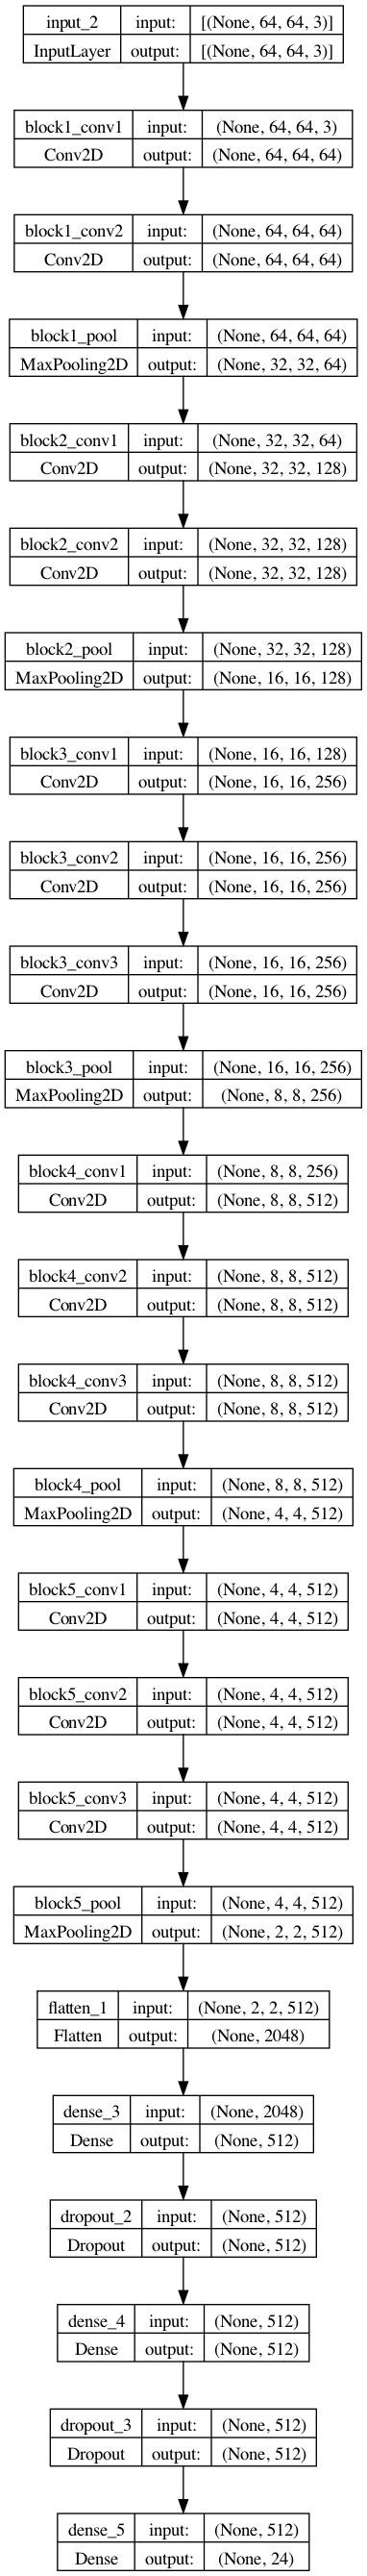

In [19]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(24, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
display(plot_model(model, to_file='vgg16.png', show_shapes=True))

In [21]:
from keras.optimizers.legacy import Adam
from keras.callbacks import ModelCheckpoint

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('vgg16_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/15
751/751 [==============================] - ETA: 0s - loss: 1.0884 - accuracy: 0.6469

/Users/teodorastereciu/anaconda3/envs/mlplsss/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


751/751 [==============================] - 692s 921ms/step - loss: 1.0884 - accuracy: 0.6469 - val_loss: 0.2585 - val_accuracy: 0.9248
Epoch 2/15
751/751 [==============================] - 753s 1s/step - loss: 0.3998 - accuracy: 0.8632 - val_loss: 0.1343 - val_accuracy: 0.9642
Epoch 3/15
751/751 [==============================] - 709s 944ms/step - loss: 0.2905 - accuracy: 0.8988 - val_loss: 0.0859 - val_accuracy: 0.9758
Epoch 4/15
751/751 [==============================] - 679s 904ms/step - loss: 0.2425 - accuracy: 0.9157 - val_loss: 0.0665 - val_accuracy: 0.9817
Epoch 5/15
751/751 [==============================] - 728s 970ms/step - loss: 0.2141 - accuracy: 0.9261 - val_loss: 0.0723 - val_accuracy: 0.9777
Epoch 6/15
751/751 [==============================] - 797s 1s/step - loss: 0.1861 - accuracy: 0.9361 - val_loss: 0.0431 - val_accuracy: 0.9881
Epoch 7/15
751/751 [==============================] - 757s 1s/step - loss: 0.1722 - accuracy: 0.9409 - val_loss: 0.0394 - val_accuracy: 0.987